In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
import cv2
import gc

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
print(f"Classes: {classes}")

Classes: ['lung_aca', 'lung_n', 'lung_scc']


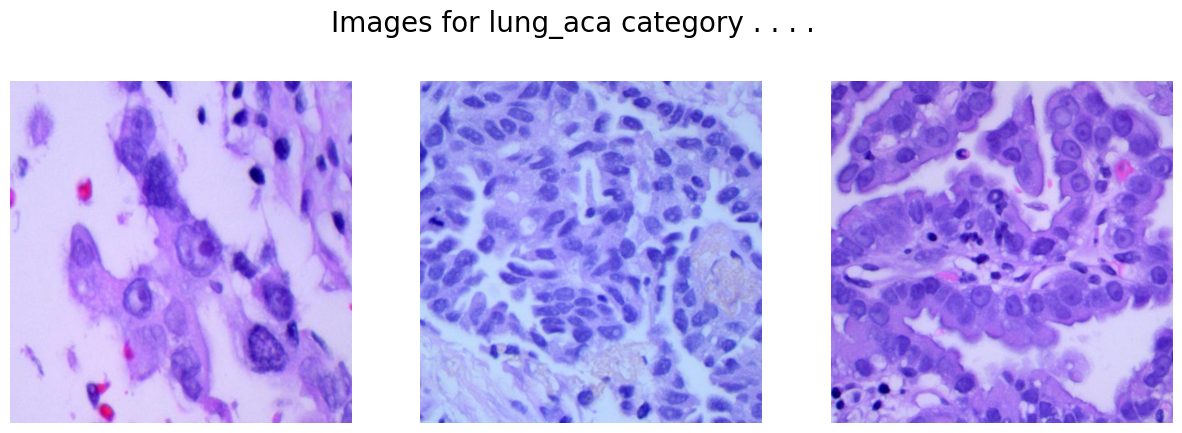

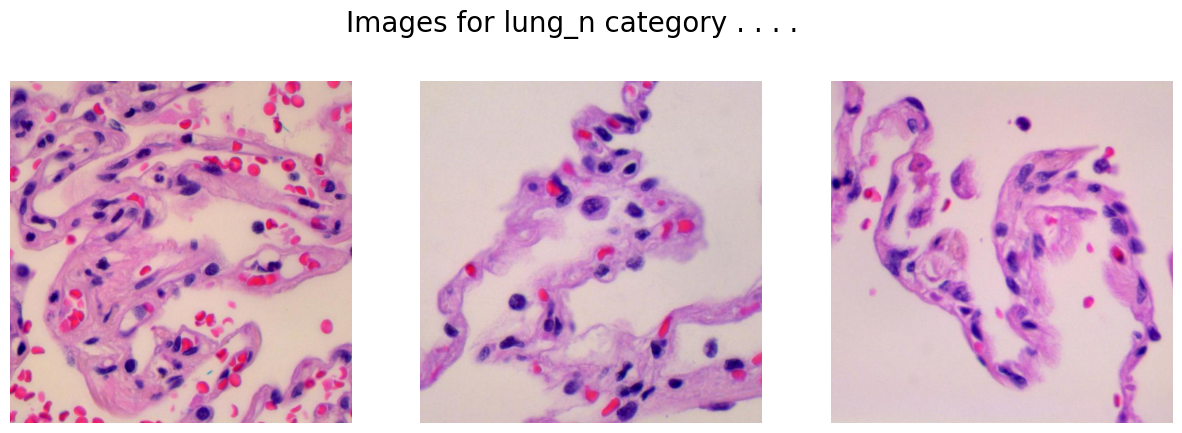

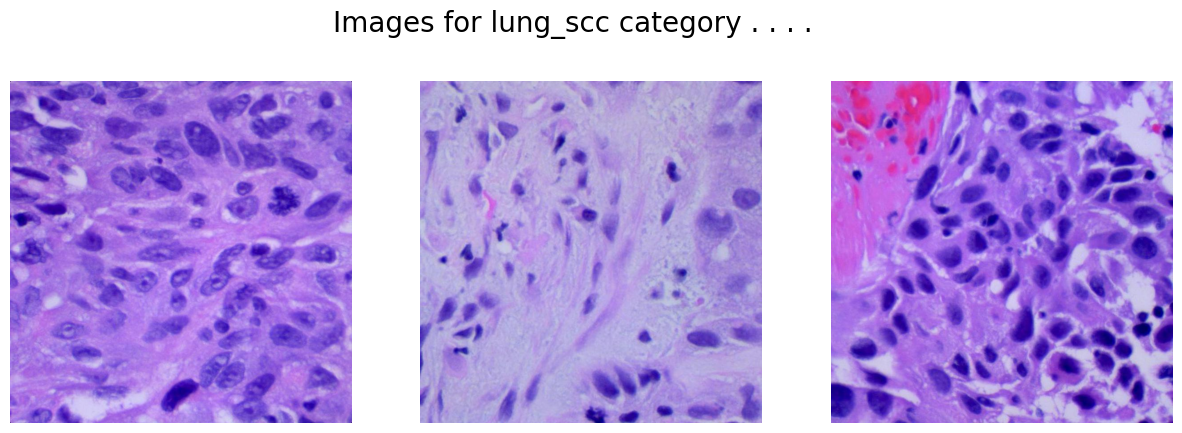

In [4]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [5]:
# Prepare data
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
Y = np.asarray(Y)


KeyboardInterrupt: 

In [ ]:
# Train-validation split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=SPLIT, random_state=2022)

In [ ]:
# Create custom dataset class
class LungImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL image for transforms
        image = Image.fromarray(image.astype('uint8'))
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create datasets
train_dataset = LungImageDataset(X_train, Y_train, transform=transform)
val_dataset = LungImageDataset(X_val, Y_val, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the model
class LungCNNSequential(nn.Module):
    def __init__(self, num_classes=3):
        super(LungCNNSequential, self).__init__()
        
        # Feature extraction layers using Sequential API
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
        )
        
        # Calculate the flattened size
        self.flat_features = 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8)
        
        # Fully connected layers using Sequential API
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Extract features
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classify
        x = self.classifier(x)
        
        return x


In [ ]:
# Instantiate the model
model = LungCNNSequential(num_classes=3)
model = model.to(DEVICE)
print("Model with Sequential components:")
print(model)


Model with Sequential components:
LungCNNSequential(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.3, inplace=False)
  )
  (class

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [ ]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [ ]:
# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [ ]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 3

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    
    # Check for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_lung_model.pth')
    else:
        early_stop_counter += 1
    
    # Early stopping check
    if early_stop_counter >= early_stop_patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break
        
    # Check if validation accuracy reached 90%
    if val_acc > 0.90:
        print('\nValidation accuracy has reached up to 90% so, stopping further training.')
        break


Epoch 1/10 | Train Loss: 0.2543 | Train Acc: 0.9031 | Val Loss: 0.1912 | Val Acc: 0.9280
Epoch 2/10 | Train Loss: 0.1418 | Train Acc: 0.9480 | Val Loss: 0.1153 | Val Acc: 0.9540
Epoch 3/10 | Train Loss: 0.0934 | Train Acc: 0.9661 | Val Loss: 0.6165 | Val Acc: 0.9350
Epoch 4/10 | Train Loss: 0.0793 | Train Acc: 0.9718 | Val Loss: 0.0893 | Val Acc: 0.9647
Epoch 5/10 | Train Loss: 0.0485 | Train Acc: 0.9824 | Val Loss: 0.1366 | Val Acc: 0.9643
Epoch 6/10 | Train Loss: 0.0474 | Train Acc: 0.9828 | Val Loss: 0.1494 | Val Acc: 0.9610
Epoch 7/10 | Train Loss: 0.0445 | Train Acc: 0.9822 | Val Loss: 0.1511 | Val Acc: 0.9483
Epoch 8/10 | Train Loss: 0.0254 | Train Acc: 0.9912 | Val Loss: 0.0655 | Val Acc: 0.9743
Epoch 9/10 | Train Loss: 0.0167 | Train Acc: 0.9948 | Val Loss: 0.0630 | Val Acc: 0.9777
Epoch 10/10 | Train Loss: 0.0107 | Train Acc: 0.9964 | Val Loss: 0.0683 | Val Acc: 0.9800


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_lung_model.pth'))

<All keys matched successfully>

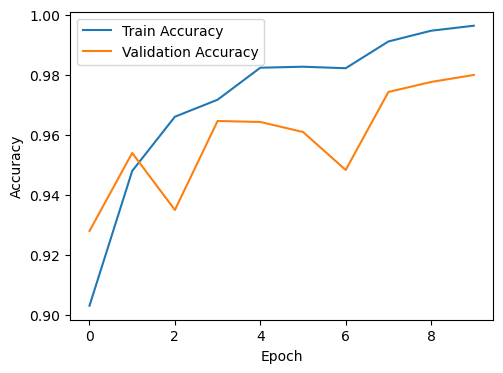

In [ ]:
history_df = pd.DataFrame(history)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_df['train_acc'], label='Train Accuracy')
plt.plot(history_df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

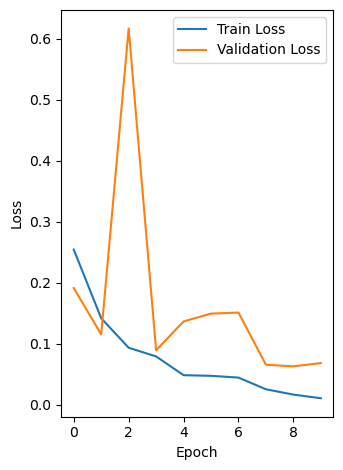

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Print classification report
print(metrics.classification_report(all_labels, all_preds, target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.93      0.87      0.90       987
      lung_n       0.99      0.99      0.99       977
    lung_scc       0.89      0.94      0.91      1036

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



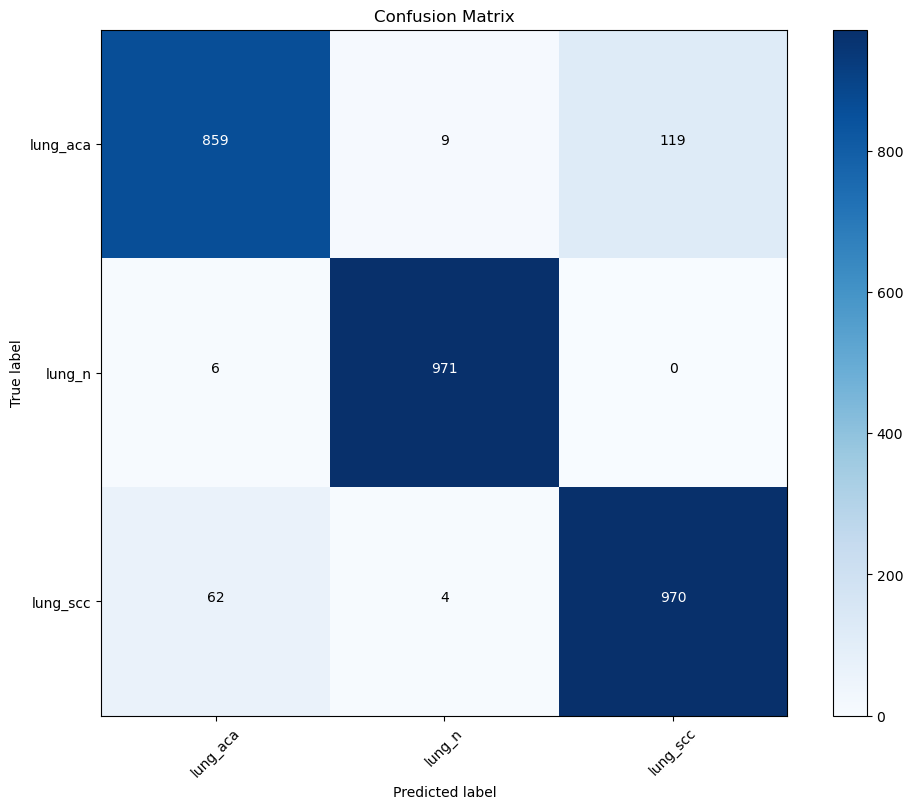

In [ ]:
# Create confusion matrix
cm = metrics.confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()